['/home/dd6849/.conda/envs/diffuserClean/lib/python310.zip', '/home/dd6849/.conda/envs/diffuserClean/lib/python3.10', '/home/dd6849/.conda/envs/diffuserClean/lib/python3.10/lib-dynload', '', '/home/dd6849/.conda/envs/diffuserClean/lib/python3.10/site-packages', '/scratch/network/dd6849/rpmml-project/rpmml-project/src']


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import random
import rpmml_project.pointmaze.point_maze_3 as pm3
import torch

In [6]:

# Use pseudo-action dataset
datasetPseudo = pm3.MinariTrajectoryDatasetWithPseudoActions(
    "D4RL/pointmaze/umaze-v2", horizon=3
)
print(f"\nDataset size: {len(datasetPseudo)} trajectory windows")
print(f"Trajectory dim (pos+skip): {datasetPseudo.traj_dim}")
# ========================================================================
# MODEL
# ========================================================================

model = pm3.EqNet(
    state_dim=datasetPseudo.traj_dim,  # 3 (x, y, skip)
    hidden_dim=128,
    time_dim=32,
    n_layers=12,
    kernel_size=3,
    use_positional_encoding=False,
)

diffusion = pm3.GaussianDiffusion(timesteps=200)
    
print(f"\nModel parameters: {sum(p.numel() for p in model.parameters()):,}")
device = "cuda" if torch.cuda.is_available() else "cpu"


Dataset size: 71193 trajectory windows
Trajectory dim (pos+skip): 3

Model parameters: 1,409,667


In [7]:
datasetNotPseudo = pm3.MinariTrajectoryDataset(
    dataset_name="D4RL/pointmaze/umaze-v2",
    horizon=32
)


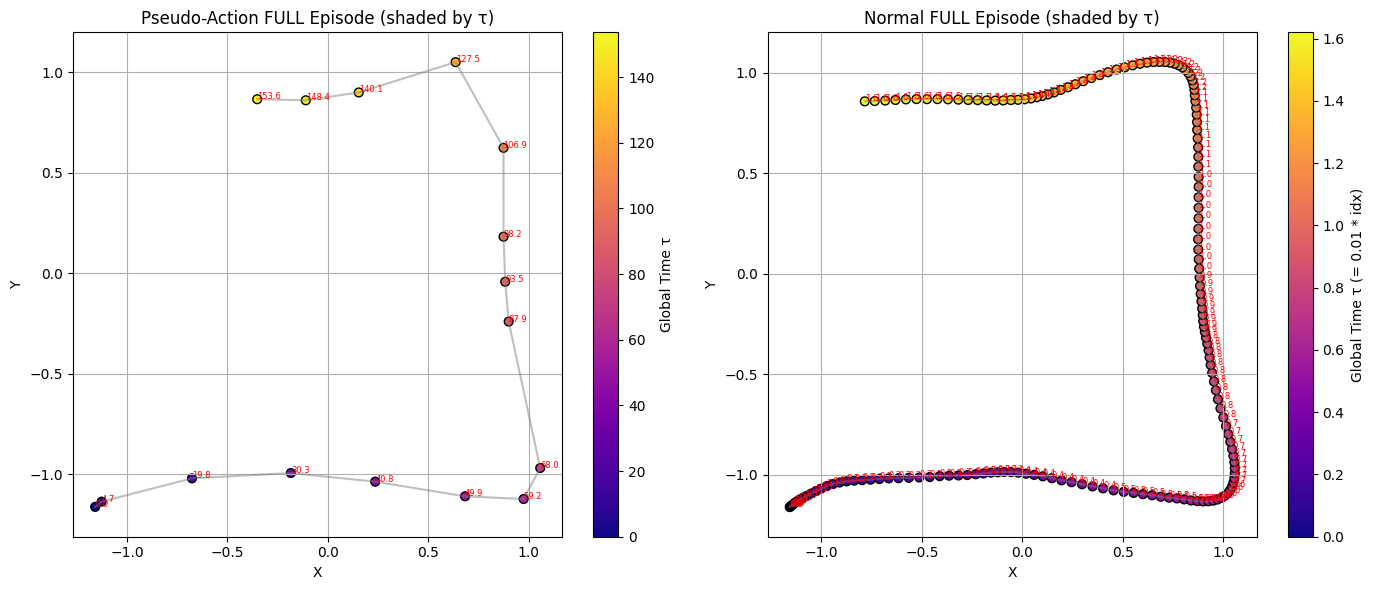

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# --------------------------------------------------------------
# FULL EPISODE FROM NORMAL MINARI DATASET
# --------------------------------------------------------------
episode = datasetNotPseudo.trajectories[0]   # (T,4)
pos_n_full = episode[:, :2]
tau_n_full = np.arange(len(pos_n_full)) * 0.01   # global time

# --------------------------------------------------------------
# FULL EPISODE FROM PSEUDO-ACTION DATASET
# --------------------------------------------------------------
skip_list = datasetPseudo.skip_trajectories[0]  # full skip-list

pos_p_full  = np.array([p   for (p, k, tau) in skip_list])
tau_p_full  = np.array([tau for (p, k, tau) in skip_list])   # global time already stored

# --------------------------------------------------------------
# PLOT
# --------------------------------------------------------------

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ============================
# LEFT: PSEUDO-ACTION FULL EPISODE (shaded by τ)
# ============================
ax = axes[0]
sc = ax.scatter(
    pos_p_full[:, 0], pos_p_full[:, 1],
    c=tau_p_full,                     # <<<<< GLOBAL TIME SHADING
    cmap="plasma",
    s=40,
    edgecolor="black"
)

ax.plot(pos_p_full[:,0], pos_p_full[:,1], color="gray", alpha=0.5)

# annotate τ
for i, tau in enumerate(tau_p_full):
    ax.text(pos_p_full[i,0], pos_p_full[i,1], f"{tau:.1f}", fontsize=6, color="red")

fig.colorbar(sc, ax=ax, label="Global Time τ")
ax.set_title("Pseudo-Action FULL Episode (shaded by τ)")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.axis("equal")
ax.grid(True)

# ============================
# RIGHT: NORMAL FULL EPISODE (shaded by τ)
# ============================
ax = axes[1]
sc2 = ax.scatter(
    pos_n_full[:,0], pos_n_full[:,1],
    c=tau_n_full,                      # <<<<< GLOBAL TIME SHADING
    cmap="plasma",
    s=40,
    edgecolor="black"
)

ax.plot(pos_n_full[:,0], pos_n_full[:,1], color="gray", alpha=0.5)

# annotate τ
for i, tau in enumerate(tau_n_full):
    ax.text(pos_n_full[i,0], pos_n_full[i,1], f"{tau:.1f}", fontsize=6, color="red")

fig.colorbar(sc2, ax=ax, label="Global Time τ (= 0.01 * idx)")
ax.set_title("Normal FULL Episode (shaded by τ)")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.axis("equal")
ax.grid(True)

plt.tight_layout()
plt.show()


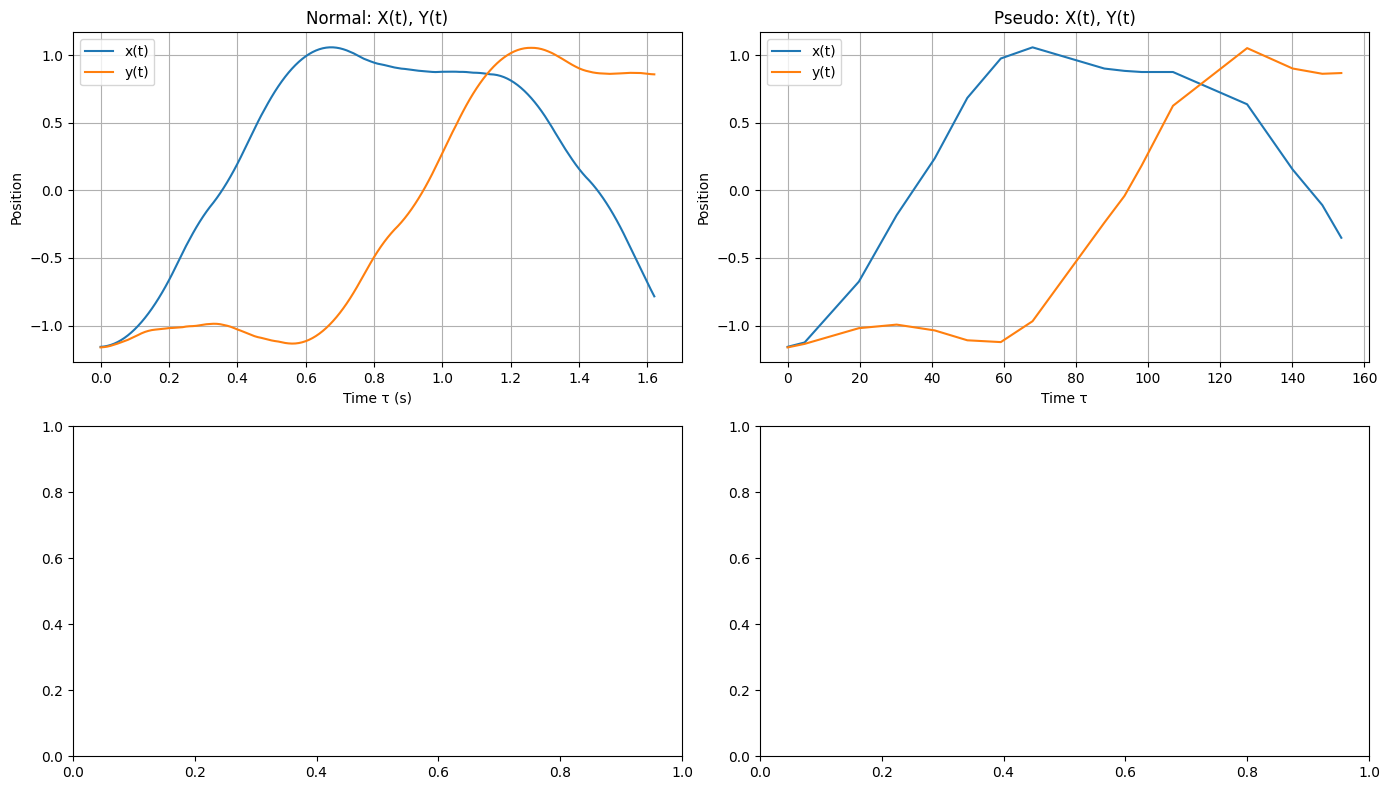

In [11]:
# ============================================================
# 1. LOAD FULL EPISODE FROM NORMAL MINARI DATASET
# ============================================================
episode = datasetNotPseudo.trajectories[0]      # (T,4)
pos_n_full = episode[:, :2]                    # (T,2)

# true environment time (0.01 per step)
tau_n_full = np.arange(len(pos_n_full)) * 0.01


# ============================================================
# 2. LOAD FULL EPISODE FROM PSEUDO-ACTION DATASET
# ============================================================
skip_list = datasetPseudo.skip_trajectories[0]  # list of (pos, skip, tau)

pos_p_full  = np.array([p   for (p, k, tau) in skip_list])
skip_p_full = np.array([k   for (p, k, tau) in skip_list])
tau_p_full  = np.array([tau for (p, k, tau) in skip_list])   # already global time

# Optional: extend final τ to continuous time (if needed)
# tau_p_final = tau_p_full[-1] + skip_p_full[-1]
# tau_p_full  = np.append(tau_p_full, tau_p_final)
# pos_p_full  = np.vstack([pos_p_full, pos_p_full[-1]])


# ============================================================
# 3. PLOT x(t), y(t) for BOTH DATASETS
# ============================================================

fig, axs = plt.subplots(2, 2, figsize=(14, 8))

# --------------------------------------------------------
# NORMAL DATASET — x(t), y(t)
# --------------------------------------------------------
axs[0,0].plot(tau_n_full, pos_n_full[:,0], label="x(t)")
axs[0,0].plot(tau_n_full, pos_n_full[:,1], label="y(t)")
axs[0,0].set_title("Normal: X(t), Y(t)")
axs[0,0].set_xlabel("Time τ (s)")
axs[0,0].set_ylabel("Position")
axs[0,0].grid(True)
axs[0,0].legend()

# --------------------------------------------------------
# PSEUDO-ACTION DATASET — x(tau), y(tau)
# --------------------------------------------------------
axs[0,1].plot(tau_p_full, pos_p_full[:,0], label="x(t)")
axs[0,1].plot(tau_p_full, pos_p_full[:,1], label="y(t)")
axs[0,1].set_title("Pseudo: X(t), Y(t)")
axs[0,1].set_xlabel("Time τ")
axs[0,1].set_ylabel("Position")
axs[0,1].grid(True)
axs[0,1].legend()

plt.tight_layout()
plt.show()

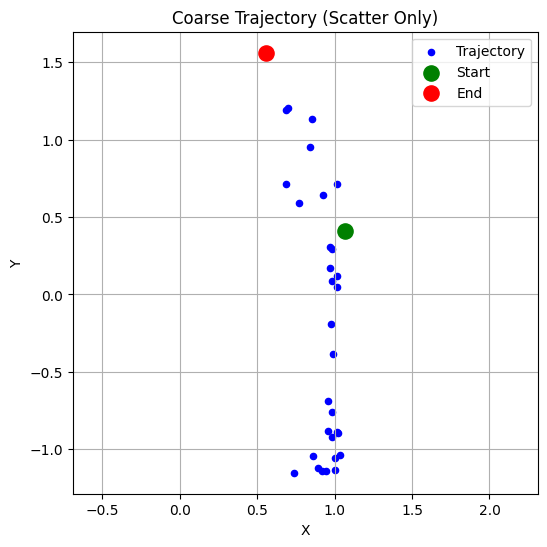